# Практическая работа 5 
## Выполнил Егоров Ю.А. студент ББМО-01-23


### Вгружаем модель

In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# Загрузка тестовых данных MNIST
(_, _), (test_images, test_labels) = mnist.load_data()

# Нормализация изображений
test_images = test_images / 255.0

# Преобразование меток в категориальный формат
test_labels = to_categorical(test_labels, num_classes=10)

# Загрузка обученной модели из предыдущих практик
ml_model = tf.keras.models.load_model('/Users/egorov_y/AZSII/practica_5/mnist_model.h5')

# Проверка точности модели до атаки
test_loss, test_acc = ml_model.evaluate(test_images, test_labels)
print(f'Точность на чистых изображениях: {test_acc}')


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step - accuracy: 0.9733 - loss: 0.0970
Точность на чистых изображениях: 0.9768000245094299


### Произведение атаки

In [5]:
!pip install foolbox

DEPRECATION: Loading egg at /opt/homebrew/lib/python3.11/site-packages/jupyterlab_widgets-3.0.9-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /opt/homebrew/lib/python3.11/site-packages/nbformat-5.9.2-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /opt/homebrew/lib/python3.11/site-packages/jedi-0.19.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /opt/homebrew/lib/python3.11/site-packages/ipykernel-6.25.2-py3.11.egg is deprecated. pip 24.3 will e

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


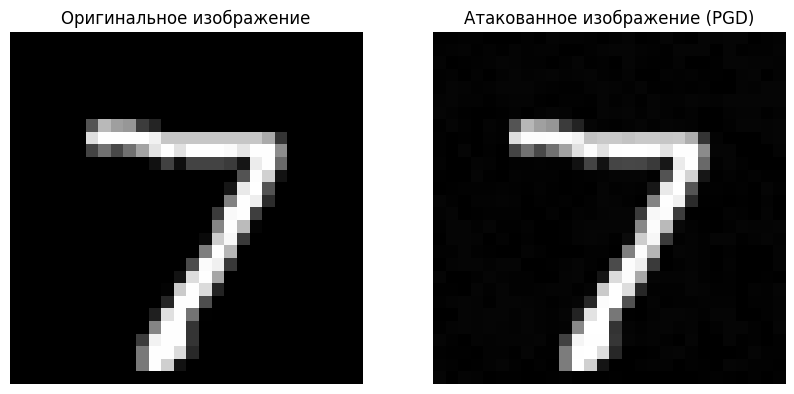

In [3]:
import torch
import torch.nn as nn
import foolbox as fb
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

fml_model = fb.TensorFlowModel(ml_model, bounds=(-1, 1))
image = tf.convert_to_tensor(test_images[0], dtype=tf.float32)[None, ...]
label = np.argmax(test_labels[0])
label = tf.convert_to_tensor(label, dtype=tf.int64)

attack = fb.attacks.LinfPGD(steps=20)
advs, _, success = attack(fml_model, image, label[None], epsilons=0.01)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Оригинальное изображение")
plt.imshow(image[0].numpy(), cmap="gray")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Атакованное изображение (PGD)")
plt.imshow(advs[0].numpy(), cmap="gray")
plt.axis('off')

plt.show()

### Оценка модели на противоречивых примерах

In [4]:
adversarial_images = []

for i in range(len(test_images)):
    image = tf.convert_to_tensor(test_images[i], dtype=tf.float32)[None, ...]
    label = np.argmax(test_labels[i])
    label = tf.convert_to_tensor(label, dtype=tf.int64)
    advs, _, success = attack(fml_model, image, label[None], epsilons=0.01)
    adversarial_images.append(advs)

adversarial_images = tf.concat(adversarial_images, axis=0)
adversarial_loss, adversarial_acc = ml_model.evaluate(adversarial_images, test_labels)
print(f'Точность на неблагоприятных примерах: {adversarial_acc}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step - accuracy: 0.9504 - loss: 0.1763
Точность на неблагоприятных примерах: 0.957099974155426


### Вывод

Точность модели на данных, подвергнутых атаке прогнозируемого градиентного спуска (FGSM), снизилась незначительно и составила 95%. Это свидетельствует о том, что данная модель обладает высокой устойчивостью к данному типу атак. Несмотря на воздействие шума, внесенного атакой, модель смогла сохранить высокий уровень точности при классификации, что указывает на её надежность и низкую уязвимость к методам FGSM. Таким образом, можно заключить, что алгоритм обучения и структура модели эффективно защищают её от атак, направленных на внесение небольших, целенаправленных искажений
